In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import aim
from aim import track

# os.environ['KMP_DUPLICATE_LIB_OK']='True'

plt.ion()   # interactive mode

In [2]:
# Hyper parameters
num_epochs = 25
num_classes = 5
batch_size = 4
learning_rate = 0.001

# aim - Track hyper parameters
track(aim.hyperparams, {
    'num_epochs': num_epochs,
    'num_classes': num_classes,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
})

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
#csua
# data_dir = '../../../datasets/memories/Image Emotion Dataset Mid'
#local
data_dir = 'ImageEmotionDatasetReduced'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
               for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)
print(class_names)
print(device)

{'train': 194, 'test': 46}
['amusement', 'awe', 'contentment', 'excitement', 'sadness']
cpu


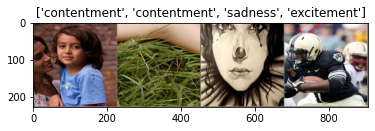

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [3]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            track(aim.metric, 'Loss', epoch_loss, epoch)
            track(aim.metric, 'Accuracy', epoch_acc, epoch)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            track(aim.checkpoint, 'checkpoint_test', 'chp_epoch_{}'.format(epoch),
              model, epoch, lr_rate=scheduler.get_last_lr(),
              meta={
                  'learning_rate': scheduler.get_last_lr(),
                  'batch_size': 4
              })

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [4]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Freeze resnet weights
for param in model_ft.parameters():
    param.requires_grad = False

# model_ft.fc = nn.Linear(num_ftrs, len(class_names))

#Dropout on last layer
model_ft.fc = nn.Sequential(
#     nn.Dropout(0.5),
    nn.Linear(num_ftrs, 512),
    nn.Dropout(0.2),
    nn.Linear(512, len(class_names))
)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

#Pretrained optimizer
optimizer_ft = optim.Adam(model_ft.fc.parameters(), lr=learning_rate)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

In [5]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/24
----------
train Loss: 2.4194 Acc: 0.2990
test Loss: 2.4017 Acc: 0.3261

Epoch 1/24
----------
train Loss: 1.9298 Acc: 0.4381
test Loss: 1.5629 Acc: 0.4348

Epoch 2/24
----------
train Loss: 2.2356 Acc: 0.4124
test Loss: 2.1251 Acc: 0.5217

Epoch 3/24
----------
train Loss: 1.7123 Acc: 0.4278
test Loss: 1.0686 Acc: 0.5217

Epoch 4/24
----------
train Loss: 1.3019 Acc: 0.5464
test Loss: 1.7595 Acc: 0.4783

Epoch 5/24
----------
train Loss: 1.2056 Acc: 0.5567
test Loss: 1.5842 Acc: 0.4783

Epoch 6/24
----------
train Loss: 1.1764 Acc: 0.5309
test Loss: 1.3800 Acc: 0.5000

Epoch 7/24
----------
train Loss: 1.2013 Acc: 0.5155
test Loss: 1.2294 Acc: 0.5435

Epoch 8/24
----------
train Loss: 1.1136 Acc: 0.5567
test Loss: 1.4488 Acc: 0.5435

Epoch 9/24
----------
train Loss: 1.3307 Acc: 0.4948
test Loss: 1.1806 Acc: 0.5000

Epoch 10/24
----------
train Loss: 0.9379 Acc: 0.6289
test Loss: 1.1903 Acc: 0.5435

Epoch 11/24
----------
train Loss: 0.9155 Acc: 0.6340
test Loss: 1.1179 Acc

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]) + '\n actual: {}'.format(class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

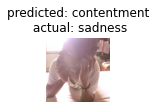

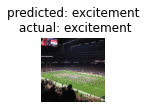

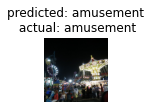

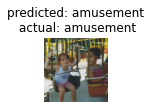

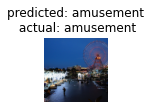

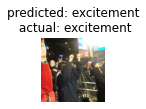

In [12]:
visualize_model(model_ft)